In [645]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [646]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,\
TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,\
Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_modechoice08,darp_solutions_modechoice08=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

Estimate Route for the  0 th household  2018-07-16 14:52:24.078179
1 9 2018-07-16 14:52:24.705221
2 16 2018-07-16 14:52:25.602267
3 13 2018-07-16 14:52:26.487321
4 27 2018-07-16 14:52:28.205421
5 9 2018-07-16 14:52:28.601449
6 9 2018-07-16 14:52:29.054477
7 8 2018-07-16 14:52:29.439498
8 9 2018-07-16 14:52:29.920522
9 8 2018-07-16 14:52:30.328551
10 7 2018-07-16 14:52:30.662565
11 11 2018-07-16 14:52:31.734631
12 12 2018-07-16 14:52:32.204658
13 4 2018-07-16 14:52:32.430670
14 9 2018-07-16 14:52:32.877698
15 14 2018-07-16 14:52:33.824753
16 14 2018-07-16 14:52:34.582802
17 11 2018-07-16 14:52:35.134829
18 8 2018-07-16 14:52:35.551860
19 6 2018-07-16 14:52:35.890872
20 5 2018-07-16 14:52:36.303898
21 6 2018-07-16 14:52:36.683921
22 10 2018-07-16 14:52:37.454964
23 19 2018-07-16 14:52:38.936053
24 18 2018-07-16 14:52:39.727102
25 14 2018-07-16 14:52:40.773164
26 6 2018-07-16 14:52:41.013173
27 11 2018-07-16 14:52:41.639212
28 6 2018-07-16 14:52:41.950232
29 5 2018-07-16 14:52:42.231246
3

In [580]:
drivingcost_per_mile=0.5

In [640]:
modechoice_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
modechoice_target_trips=modechoice_target_trips[(modechoice_target_trips.orig_taz!=modechoice_target_trips.dest_taz) | (modechoice_target_trips.trip_counter==1)]
modechoice_target_trips=modechoice_target_trips.append(traveler_trips[traveler_trips.tripmode>8])

In [641]:
modechoice_target_trips=prd.compare_mode_utlity(modechoice_target_trips,TransitMazTazFlag,
                                               three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                                               Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                                               Vehicular_Skim_Dict1,superzone_map,drivingcost_per_mile,transit_zone_dict)

In [642]:
modechoice_target_trips.value_of_time=modechoice_target_trips.value_of_time*0.8

In [643]:
modechoice_target_trips['car_utility']=modechoice_target_trips.apply(lambda row: 
        (prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile)), axis=1)
    
modechoice_target_trips['predicted_mode']=modechoice_target_trips.apply(lambda row:
    'NonCar' if row.transit_utility<row.car_utility else 'Car',axis=1)

In [644]:
modechoice_target_trips.groupby(['predicted_mode']).count()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,early_penalty_threshold,late_penalty_threshold,transit_time,transit_walk_time,transit_utility,car_time,car_dist,toll_cost,car_utility,actual_mode
predicted_mode,,,,,,,,,,,,,,,,,,,,,
Car,180250,180250,180250,180250,180250,180250,180250,180250,180250,180250,...,180250,180250,180250,180250,180250,180250,180250,180250,180250,180250
NonCar,11939,11939,11939,11939,11939,11939,11939,11939,11939,11939,...,11939,11939,11939,11939,11939,11939,11939,11939,11939,11939


In [438]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar=pd.read_csv(output_filepath+'route_info.csv')
darp_solution=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='40'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar15,darp_solution_callcar15,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

2018-07-15 08:30:57.337732
2018-07-15 08:31:34.340906
1000 2018-07-15 08:31:41.024304
2000 2018-07-15 08:31:45.311556
3000 2018-07-15 08:31:49.620809
4000 2018-07-15 08:31:54.148076
5000 2018-07-15 08:31:57.870294
6000 2018-07-15 08:32:00.228427
7000 2018-07-15 08:32:02.762577
8000 2018-07-15 08:32:05.238722
10000 2018-07-15 08:32:09.712991
12000 2018-07-15 08:32:14.796284
13000 2018-07-15 08:32:17.741462
15000 2018-07-15 08:32:23.956827
16000 2018-07-15 08:32:26.711990
17000 2018-07-15 08:32:29.608154
18000 2018-07-15 08:32:32.320314
20000 2018-07-15 08:32:37.973651
21000 2018-07-15 08:32:41.242838
22000 2018-07-15 08:32:44.960057
23000 2018-07-15 08:32:49.296317
24000 2018-07-15 08:32:53.752574
25000 2018-07-15 08:32:57.959822
26000 2018-07-15 08:33:02.048069
27000 2018-07-15 08:33:06.166303
28000 2018-07-15 08:33:10.340554
29000 2018-07-15 08:33:14.512794
30000 2018-07-15 08:33:18.557037
31000 2018-07-15 08:33:23.439319
32000 2018-07-15 08:33:28.129597
33000 2018-07-15 08:33:32.1818

In [500]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar15=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_callcar15=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor=''
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar15,darp_solution_callcar15,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

2018-07-15 20:39:41.818367
2018-07-15 20:40:17.553462
1000 2018-07-15 20:40:23.744826
2000 2018-07-15 20:40:27.739061
3000 2018-07-15 20:40:31.841307
4000 2018-07-15 20:40:36.066550
6000 2018-07-15 20:40:41.420866
7000 2018-07-15 20:40:43.438989
8000 2018-07-15 20:40:45.523106
9000 2018-07-15 20:40:47.413218
11000 2018-07-15 20:40:51.300446
13000 2018-07-15 20:40:55.621700
14000 2018-07-15 20:40:57.965837
19000 2018-07-15 20:41:10.187556
20000 2018-07-15 20:41:12.572696
21000 2018-07-15 20:41:14.968837
22000 2018-07-15 20:41:17.316980
23000 2018-07-15 20:41:20.124145
24000 2018-07-15 20:41:23.710352
25000 2018-07-15 20:41:27.214557
26000 2018-07-15 20:41:30.819769
27000 2018-07-15 20:41:34.384978
28000 2018-07-15 20:41:37.911190
29000 2018-07-15 20:41:41.588401
30000 2018-07-15 20:41:45.150616
32000 2018-07-15 20:41:52.460045
33000 2018-07-15 20:41:56.131256
34000 2018-07-15 20:41:59.771470
35000 2018-07-15 20:42:03.445691
36000 2018-07-15 20:42:07.018897
37000 2018-07-15 20:42:10.5901

In [499]:
run_name='allhhcartrip1.25/'
output_filepath='Output/'+run_name
route_info_allcar125=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_allcar125=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='40'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar,darp_solution_allcar125,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

2018-07-15 20:27:29.047744
2018-07-15 20:28:05.296875
1000 2018-07-15 20:28:11.483240
2000 2018-07-15 20:28:15.516476
3000 2018-07-15 20:28:19.490709
4000 2018-07-15 20:28:23.460942
6000 2018-07-15 20:28:29.070272
10000 2018-07-15 20:28:36.964741
11000 2018-07-15 20:28:38.783843
13000 2018-07-15 20:28:42.978089
14000 2018-07-15 20:28:45.215226
16000 2018-07-15 20:28:50.217520
17000 2018-07-15 20:28:52.689661
18000 2018-07-15 20:28:55.027798
20000 2018-07-15 20:28:59.847080
21000 2018-07-15 20:29:02.139216
22000 2018-07-15 20:29:04.508356
23000 2018-07-15 20:29:07.347522
24000 2018-07-15 20:29:10.993736
25000 2018-07-15 20:29:14.593948
26000 2018-07-15 20:29:18.194159
27000 2018-07-15 20:29:21.743368
28000 2018-07-15 20:29:25.559597
29000 2018-07-15 20:29:29.412824
30000 2018-07-15 20:29:33.147044
31000 2018-07-15 20:29:36.697252
32000 2018-07-15 20:29:40.686487
33000 2018-07-15 20:29:44.679717
34000 2018-07-15 20:29:48.450937
35000 2018-07-15 20:29:52.249162
36000 2018-07-15 20:29:55.8

In [497]:
run_name='modechoice1.1/'
output_filepath='Output/'+run_name
route_info_modechoice10=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_modechoice10=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath
external_factor='40'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_modechoice10,darp_solution_modechoice10,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

# dtd.route_to_vehiclepathdat(route_info_modechoice10,origin_links,output_filepath,
#                             vehicle_filepath,path_filepath,superzone_map,
#                                 intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

2018-07-15 20:01:31.043573
2018-07-15 20:02:19.102399
1000 2018-07-15 20:02:26.604845
2000 2018-07-15 20:02:30.547076
3000 2018-07-15 20:02:34.433304
4000 2018-07-15 20:02:38.476542
5000 2018-07-15 20:02:42.405768
6000 2018-07-15 20:02:45.465947
7000 2018-07-15 20:02:47.768084
11000 2018-07-15 20:02:56.095578
12000 2018-07-15 20:02:58.315703
13000 2018-07-15 20:03:00.548834
15000 2018-07-15 20:03:05.333116
16000 2018-07-15 20:03:07.894267
17000 2018-07-15 20:03:10.710437
18000 2018-07-15 20:03:13.722608
19000 2018-07-15 20:03:16.605783
20000 2018-07-15 20:03:19.409948
22000 2018-07-15 20:03:24.617254
26000 2018-07-15 20:03:35.191871
27000 2018-07-15 20:03:38.818083
28000 2018-07-15 20:03:42.516301
29000 2018-07-15 20:03:46.144515
30000 2018-07-15 20:03:49.779728
31000 2018-07-15 20:03:53.524953
32000 2018-07-15 20:03:57.238166
34000 2018-07-15 20:04:04.585598
35000 2018-07-15 20:04:08.157813
36000 2018-07-15 20:04:11.842030
37000 2018-07-15 20:04:15.483238
38000 2018-07-15 20:04:19.205

In [435]:
community_solution_allcar15=pod.load_obj('community_allcar15','Output/')

In [436]:
community_solution_allcar15

{'cav_use_mode': 1,
 'drivingcost_per_mile': 1,
 'hh_num_trips': 106,
 'num_cav': 5,
 'reward_mode': 2,
 'route_info':     orig_zone  dest_zone  orig_node_index  dest_node_index  person_id  \
 0          10          8               99              100    4197662   
 1           8          7              100              205    6823742   
 2           7          9              205              206    6823742   
 3           9          5              206              104          0   
 4           5          7              104              210    5983093   
 5           7          5              210              106          0   
 6           5          7              106              212    3065366   
 0           7         10               92               93    3260786   
 1          10         12               93              198    7511987   
 2          12          7              198              199    7511987   
 0           2          7               90              196    30653

In [487]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
community_hh_list=[972044,972024,2212041,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
pod.analysis_one_hh_result(937968,[community_solution_allcar15],community_trips,5,Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


KeyError: 4197662

[3260909 3260908 3260903 3260792 3260786 3260784 3260791 3260785 7511986
 7511987 7511929 7511928 3065366 3065367 7923628 7923630 7923627 7923631
 4197661 4197662 5983094 5983093 5983092 6823741 6823742 6925729 6925730]


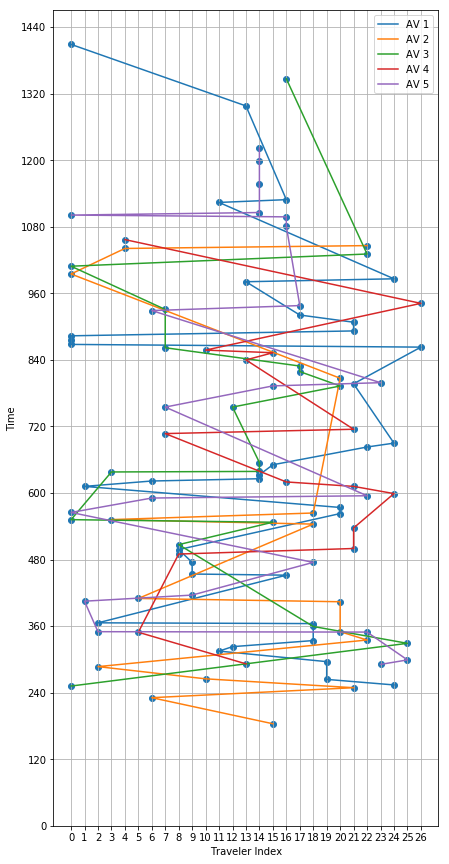

In [492]:
pod.plot_route_info_schedule(community_solution_allcar15['route_info'],community_trips,5)